In [1]:
#!pip install plotly --upgrade
#!pip install ipywidgets

# basic function

In [1]:
import time

def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Tiempo de ejecución de '{func.__name__}': {elapsed_time:.6f} segundos")
        return result
    return wrapper

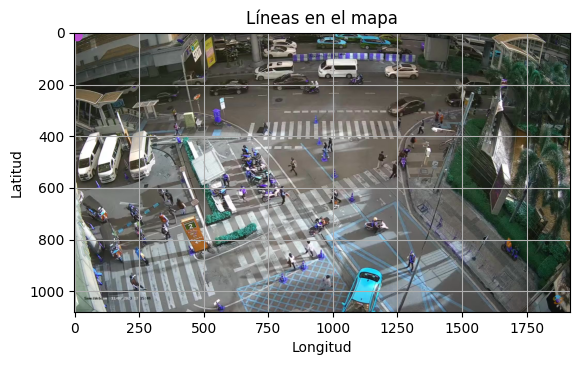

In [2]:
import matplotlib.pyplot as plt
import random
import cv2

def plot_lines_on_map(lines, color1=None, title=None, image=None):
    if image is None:
        fondo = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"
        fondo = cv2.imread(fondo)
    else:
        fondo = 255*np.ones([2000, 2000, 3], np.uint8)
    
    if color1 is None:
        color1 = (random.random(), random.random(), random.random())

    if title is None:
        title = 'Líneas en el mapa'

    # Graficar las líneas en el mapa
    for line_points in lines:
        # Extraer las coordenadas de latitud y longitud de cada punto en la línea
        latitudes, longitudes = zip(*line_points)
        
        # Graficar la línea usando matplotlib
        plt.plot(longitudes, latitudes, color=color1, marker='o')

    # Guardar el gráfico de matplotlib
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.imshow(fondo)
    plt.title(title)
    plt.grid(True)
    plt.savefig('lineas_en_mapa.png')
    plt.show()


# Example data for three lines with different points
line1 = [(0, 0), (1, 1), (2, 2), (3, 3)]
line2 = [(4, 4), (5, 5), (6, 6)]
line3 = [(7, 7), (8, 8), (9, 9), (10, 10), (11, 11)]

# Plot the lines on the map
lines_to_plot = [line1, line2, line3]
plot_lines_on_map(lines_to_plot)

In [3]:
def graficar_con_sombras(lista1, lista2):
    fondo = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"
    fondo = cv2.imread(fondo)
    
    # Obtener las coordenadas x e y de cada lista
    x1, y1 = zip(*lista1)
    x2, y2 = zip(*lista2)
    
    # Interpolar ambas listas para obtener funciones continuas
    f1 = interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f2 = interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')
    
    # Crear una nueva lista de puntos para evaluar la diferencia entre las funciones
    x_new = np.linspace(max(min(x1), min(x2)), min(max(x1), max(x2)), 1000)
    
    # Evaluar las funciones en los nuevos puntos
    y1_new = f1(x_new)
    y2_new = f2(x_new)
    
    # Graficar el área sombreada entre las dos listas
    polygon_points = list(zip(x1, y1)) + list(zip(reversed(x2), reversed(y2)))
    polygon = Polygon(polygon_points, edgecolor='gray', facecolor='gray', alpha=0.5)    
    
    # Graficar las dos listas de puntos
    plt.plot(x1, y1, label='Lista 1', marker='o')
    plt.plot(x2, y2, label='Lista 2', marker='o')
    
    # Agregar el polígono al gráfico para sombrear el área
    plt.gca().add_patch(polygon)
    
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.imshow(fondo)
    plt.legend()
    plt.title('Área entre dos listas de puntos')
    plt.grid(True)
    plt.show()

In [4]:
def export_graph(lineas_semejantes_lista, all_lines, all_names):
    imagen_path = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"
    img = Image.open(imagen_path)
    img = img.convert('L')

    factor_brillo = 1.0  # Puedes ajustar este valor para hacer la imagen más clara o más oscura
    img = ImageEnhance.Brightness(img)
    img = img.enhance(factor_brillo)
    
    img_array = np.array(img)
    img_array = np.stack((img_array,) * 3, axis=-1)

    fig = go.Figure()
    fig.add_trace(go.Image(z=img_array))  # image for background

    for j, group in enumerate(lineas_semejantes_lista):
        line_color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        group_lines = []
        group_names = []
        for id in group:
            group_lines.append(all_lines[id])
            group_names.append(all_names[id])

        for i, line_points in enumerate(group_lines):
            x_coords, y_coords = zip(*line_points)
            name = group_names[i]
            fig.add_trace(go.Scatter(x=x_coords, y=y_coords, mode='markers+lines', name=f'{j}-{name}', 
                                     line=dict(color=f'rgb{line_color}')))

    fig.update_layout(title='Líneas sobre la imagen')
    pyo.plot(fig, filename='/serverstorage/interactive_image2.html')

In [5]:
#!pip install shapely
import math
from scipy import interpolate
import numpy as np
from matplotlib.patches import Polygon
from scipy.spatial import procrustes


def calcular_procrustes(lista1, lista2, umbral=1.15):
    # Convertir las listas de puntos a matrices numpy
    matriz1 = np.array(lista1)
    matriz2 = np.array(lista2)
    
    # Asegurarse de que ambas matrices tengan la misma cantidad de columnas (2 para coordenadas x e y)
    if matriz1.shape[1] != matriz2.shape[1]:
        print("Las matrices deben tener la misma cantidad de columnas para compararlas.")
    else:
        # Interpolar ambas listas para obtener la misma cantidad de puntos
        cantidad_puntos = 1000
        x1, y1 = matriz1[:, 0], matriz1[:, 1]
        x2, y2 = matriz2[:, 0], matriz2[:, 1]
        f1 = interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')
        f2 = interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')
        x_new = np.linspace(max(min(x1), min(x2)), min(max(x1), max(x2)), cantidad_puntos)
        matriz1_interp = np.column_stack((x_new, f1(x_new)))
        matriz2_interp = np.column_stack((x_new, f2(x_new)))
    
        # Aplicar el algoritmo de Procrustes para obtener la transformación óptima
        mtx1, mtx2, disparidad = procrustes(matriz1_interp, matriz2_interp)
    
        # Calcular la distancia entre las dos formas después de la transformación
        distancia_procrustes = np.sqrt(np.sum((mtx1 - mtx2) ** 2))
    
        
        #print("similares", distancia_procrustes<0.1)

        return round(distancia_procrustes, 5), distancia_procrustes<=umbral


def calcular_area(lista1, lista2, umbral=5000):
    # Obtener las coordenadas x e y de cada lista
    x1, y1 = zip(*lista1)
    x2, y2 = zip(*lista2)
    
    # Interpolar ambas listas para obtener funciones continuas
    f1 = interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    f2 = interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')
    
    # Crear una nueva lista de puntos para evaluar la diferencia entre las funciones
    x_new = np.linspace(max(min(x1), min(x2)), min(max(x1), max(x2)), 1000)
    
    # Evaluar las funciones en los nuevos puntos
    y1_new = f1(x_new)
    y2_new = f2(x_new)
    
    # Calcular la diferencia entre las dos funciones
    diferencia = y1_new - y2_new
    
    # Calcular el área entre las dos listas utilizando la integración numérica (método del trapecio)
    area = np.trapz(np.abs(diferencia), x_new)

    area = abs(area)
    
    return round(area, 3), area<=umbral

# read data features for each vehicle and save in file each coodinates

In [7]:
import pickle
import os
import pandas as pd

if False:
    all_lines = []
    all_names = []
    
    all_dataframe = {} 
    
    directorio = "/serverstorage/dataset_tailandia"
    contenido_directorio = list(sorted([ f for f in os.listdir(directorio) if f.find("csv") > 0 ]))
    
    for file in contenido_directorio:
        
        # Ruta del archivo CSV
        ruta_archivo_csv = directorio + "/" + file
        
        # Leer el archivo CSV y crear un DataFrame
        dataframe = pd.read_csv(ruta_archivo_csv)
        all_dataframe[file.split(".")[0]] = dataframe
    
        line = list(zip( dataframe["original_coordinate_x"], dataframe["original_coordinate_y"] ))
        all_lines.append(line)
        all_names.append(file.split(".")[0])
        
        # Mostrar el DataFrame
        # dataframe.head()
        
    print(len(all_lines), len(all_names))
    with open("/serverstorage/dataset_tailandia/calibration_dataset.pkl", 'wb') as file:
        pickle.dump([all_lines, all_names], file)

# read file with each coordinates

In [7]:
import pickle

all_lines_saved, all_names_saved = None, None

with open("/serverstorage/dataset_tailandia/calibration_dataset.pkl", 'rb') as archivo:
    all_lines_saved, all_names_saved = pickle.load(archivo)
    
#part_start = 0
#part_end = -1
#all_lines, all_names = all_lines[part_start:part_end],  all_names[part_start:part_end]
    
    
print(len(all_lines_saved), len(all_names_saved))
    
# quitando los que se consideran anomalia

anomalies = {
    "0082": None,
    "0130": None,
    "0317": None,
    "0326": None,
    "0275": None,
    }

for name_delete in anomalies.keys():
    if name_delete in all_names_saved:
        index = all_names_saved.index(name_delete)
        if index >= 0:
            all_names_saved.remove(name_delete)
            anomalies[name_delete] = all_lines_saved.pop(index)
            print(f"remove {name_delete}")
    
print(len(all_lines_saved), len(all_names_saved))


170 170
remove 0082
remove 0130
remove 0317
remove 0326
remove 0275
165 165


# graph

In [9]:
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
from PIL import Image, ImageEnhance
import numpy as np


def print_graph(lineas_semejantes_lista, todas_las_lineas):
    plt.figure(figsize=(20,8))
    
    fondo = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"
    fondo = cv2.imread(fondo, cv2.IMREAD_GRAYSCALE)
    fondo = cv2.cvtColor(fondo, cv2.COLOR_GRAY2BGR)

    radius = 5
    thickness = 5

    for j, group in enumerate(lineas_semejantes_lista):
        color1 = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        group_lines = []
        for id in group:
            group_lines.append(todas_las_lineas[id])

        for coordinates in group_lines:

            for i, coordinate in enumerate(coordinates):
                fondo = cv2.circle(fondo, coordinate, radius, color1, thickness)

            for i, coordinate in enumerate(coordinates[:-1]):
                desde = coordinate
                hasta = coordinates[i+1]
                fondo = cv2.line(fondo, desde, hasta , color1, thickness )

    
    plt.title(f'Movimientos actuales del vehiculo')
    plt.imshow(fondo)
    plt.axis('off')
    plt.show()

def export_graph(lineas_semejantes_lista, all_lines, all_names):
    imagen_path = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"
    img = Image.open(imagen_path)
    img = img.convert('L')

    factor_brillo = 1.0  # Puedes ajustar este valor para hacer la imagen más clara o más oscura
    img = ImageEnhance.Brightness(img)
    img = img.enhance(factor_brillo)
    
    img_array = np.array(img)
    img_array = np.stack((img_array,) * 3, axis=-1)

    fig = go.Figure()
    fig.add_trace(go.Image(z=img_array))  # image for background

    for j, group in enumerate(lineas_semejantes_lista):
        line_color = (np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))

        group_lines = []
        group_names = []
        for id in group:
            group_lines.append(all_lines[id])
            group_names.append(all_names[id])

        for i, line_points in enumerate(group_lines):
            x_coords, y_coords = zip(*line_points)
            name = group_names[i]
            fig.add_trace(go.Scatter(x=x_coords, y=y_coords, mode='markers+lines', name=f'{j}-{name}', line=dict(color=f'rgb{line_color}')))

    fig.update_layout(title='Líneas sobre la imagen')
    pyo.plot(fig, filename='/serverstorage/interactive_image2.html')

# ClusterAlgoritmia

In [8]:
from scipy.spatial.distance import directed_hausdorff
from collections import defaultdict
from itertools import chain


class ClusterAlgoritmia:
    
    lineas_semejantes_lista = []
    trained = False
    
    def __init__(self, sensibility):
        self.sensibility = sensibility
    
    def train(self, all_lines):
        self.all_lines = all_lines.copy()
    
    def predict(self, new_vehicles):
        predictions = []
        for new_vehicle in new_vehicles:
            
            all_lines_class = self.all_lines
            
            self.before = len(all_lines_class)

            if isinstance(new_vehicle, list):
                all_lines_class.append(new_vehicle)
            else:
                #print("No se puede predecir ", new_vehicle)
                pass
            
            after = len(all_lines_class)
            
            self.lineas_semejantes_lista = self.get_semejantes(all_lines_class, self.sensibility)
            
            self.trained = True

            if isinstance(new_vehicle, list):
                for i, similar_list in enumerate(self.lineas_semejantes_lista):                    
                    if after in similar_list:                    
                        predictions.append(i)   
                    
        return predictions

    def get_semejantes(self, todas_las_lineas, umbral_similitud = 45):
        # Diccionario para almacenar las distancias de Hausdorff entre cada par de líneas
        distancias_hausdorff = {}
    
        # Calcular la distancia de Hausdorff entre cada par de líneas
        for i, linea_a in enumerate(todas_las_lineas):
            for j, linea_b in enumerate(todas_las_lineas):
                if i != j:  # Evitar comparar una línea consigo misma
                    distancia = directed_hausdorff(linea_a, linea_b)[0]
                    distancias_hausdorff[(i, j)] = distancia
    
    
    
        # Encontrar las líneas semejantes basadas en el umbral
        lineas_semejantes = []
        for par, distancia in distancias_hausdorff.items():
            if distancia < umbral_similitud:
                linea_a_idx, linea_b_idx = par
                lineas_semejantes.append((linea_a_idx, linea_b_idx))
    
        # Mostrar el resultado de las líneas semejantes
        pares_semejantes = []
        for idx_a, idx_b in lineas_semejantes:
            # print(f"\tLínea {idx_a + 1} es semejante a Línea {idx_b + 1}")
            pares_semejantes.append([idx_a + 1, idx_b + 1])
            
            
        # *********************************************************************************
        # usando un grafo saco todos los puntos que se unen
    
        
        # Crear un grafo utilizando un diccionario defaultdict
        grafo = defaultdict(list)
        for a, b in pares_semejantes:
            grafo[a].append(b)
            grafo[b].append(a)
    
        
    
        # Encontrar todas las componentes conectadas del grafo
        componentes_conectadas = []
        visitados = set()
        for nodo in grafo:
            if nodo not in visitados:
                componente = self.encontrar_componente_conectada(nodo, grafo)
                componentes_conectadas.append(componente)
                visitados.update(componente)
    
        # Convertir las componentes conectadas en una lista de listas
        lineas_semejantes_lista = [list(componente) for componente in componentes_conectadas]
        
        return lineas_semejantes_lista

    # Función para encontrar la componente conectada desde un nodo dado
    def encontrar_componente_conectada(self, nodo, grafo):
        visitados = set()
        componente = set()
        pila = [nodo]

        while pila:
            actual = pila.pop()
            if actual not in visitados:
                visitados.add(actual)
                componente.add(actual)
                pila.extend(grafo[actual])

        return componente
        
    def brothers(self, cluster):
        if self.trained:        
            conten_cluster = []
            for d in self.lineas_semejantes_lista[cluster]:
                if d < len(self.all_lines):
                    conten_cluster.append(d-1)      
            return conten_cluster
        return []


    @property
    def get_clusters(self):
        temp = []
        for cluster in range(len(self.lineas_semejantes_lista)):
            conten_cluster = self.brothers(cluster)
            temp.append(conten_cluster)
        return temp





# Model_RandomForestClassifier

In [11]:
#!pip install imbalanced-learn
#!pip install xgboost
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
#from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


class Model_RandomForestClassifier:
    max_puntos = 0
    family = []

    def __init__(self, clusters=None):
        self.clusters = clusters
    
    def prepare_train(self, trayectorias):
        # Encontrar el número máximo de puntos en una trayectoria
        max_puntos = max(len(trayectoria) for trayectoria in trayectorias)
        
        # Representar cada trayectoria con puntos de referencia
        puntos_referencia = np.zeros((len(trayectorias), max_puntos, 2))
        for i, trayectoria in enumerate(trayectorias):
            puntos_referencia[i, :len(trayectoria)] = trayectoria
        
        # Aplanar la matriz para entrenar el modelo K-means
        datos_entrenamiento = puntos_referencia.reshape(len(trayectorias), -1)
        self.max_puntos = max_puntos
        return datos_entrenamiento
    
    def prepare_predict(self, nuevas_trayectorias):
        # Representar las nuevas trayectorias con puntos de referencia
        puntos_referencia_nuevas = np.zeros((len(nuevas_trayectorias), self.max_puntos, 2))
        for i, trayectoria in enumerate(nuevas_trayectorias):
            puntos_referencia_nuevas[i, :len(trayectoria)] = trayectoria
        
        # Aplanar la matriz para realizar la predicción con K-means
        datos_prediccion = puntos_referencia_nuevas.reshape(len(nuevas_trayectorias), -1)
        return datos_prediccion    

    def create_model(self, X_train, y_train):
        # Crear el modelo Random Forest
        modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Entrenar el modelo con los datos de entrenamiento
        modelo_rf.fit(X_train, y_train)
        return modelo_rf

    def create_model_unbalanced(self, X_train, y_train):
        modelo_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
        
        # Entrenar el modelo con los datos de entrenamiento
        modelo_rf.fit(X_train, y_train)
        return modelo_rf
    def train(self, X, y, test_all=False):
        self.X = X
        self.y = y
        X = self.prepare_train(X)
        
        # Dividir los datos en conjuntos de entrenamiento y prueba
        print("Before split:", Counter(y))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)     

        # intento de ampliar los datos para mitigar el desbalanceo en las clases minotiratias
        #smote = SMOTE(sampling_strategy='auto', random_state=42)
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        
        print("After split:", Counter(y_train), " - ", Counter(y_test))

        modelo_rf = self.create_model(X_train, y_train)
        #modelo_rf = self.create_model_unbalanced(X_train, y_train)

        # Realizar predicciones en el conjunto de prueba
        if test_all:
            y_pred = modelo_rf.predict(X)
            y_test = y
        else:
            y_pred = modelo_rf.predict(X_test)
        
        # Calcular la precisión del modelo
        precision = accuracy_score(y_test, y_pred)
        print(f"Precisión del modelo: {precision:.2f}")
        
        # Mostrar el reporte de clasificación
        reporte_clasificacion = classification_report(y_test, y_pred)#, target_names=names)
        matriz_confusion = confusion_matrix(y_test, y_pred)

        self.modelo_rf = modelo_rf
        
        self.__save()

        self.family = list(set(y))
        
        return reporte_clasificacion, matriz_confusion

    def predict(self, new_data):
        datos_prediccion = self.prepare_predict(data_predict)

        # Realizar predicciones en el conjunto de prueba
        y_pred = self.modelo_rf.predict(datos_prediccion)
        return y_pred

    @property
    def get_family(self):
        return self.family

    def get_brothers(self, cluster):
        brothers = []
        for i in self.clusters[cluster]:
            brothers.append( self.X[i] )
        return brothers

    def __save(self):
        with open("Model_RandomForestClassifier.pkl", 'wb') as file:
            pickle.dump([
                self.modelo_rf, 
                self.X,
                self.y,
                self.max_puntos,
                self.clusters
            ], file)

    def load(self):
        with open("Model_RandomForestClassifier.pkl", 'rb') as file:
            self.modelo_rf, self.X, self.y, self.max_puntos, self.clusters = pickle.load(file)

# crear cluster con ClusterAlgoritmia

In [12]:
@timeit
def cluster_by_ClusterAlgoritmia():
    k_william = ClusterAlgoritmia(sensibility=50.0)
    k_william.train(all_lines_saved)
    
    cluster = k_william.predict([0])

    return k_william

k_william = cluster_by_ClusterAlgoritmia()

Tiempo de ejecución de 'cluster_by_ClusterAlgoritmia': 3.451675 segundos


In [13]:
from collections import Counter


@timeit
def cluster_by_ClusterAlgoritmia(k_william):
    sumary_input = {}
    for clust, ids_cluster in enumerate(k_william.get_clusters):
        sumary_input[clust] = len(ids_cluster)
    print( sumary_input )

    print("\nEvaluando si los cluster son correctos")

    others = []
    
    all_clusters = []
    all_ids = []
    all_groups = []
    for clust, ids_cluster in enumerate(k_william.get_clusters):
        group = []
        for id_line1, id_p in enumerate(ids_cluster):
            linea1 = all_lines_saved[id_p]
            """
            if len(ids_cluster[id_line1+1:])>0:
                for id_line2 in ids_cluster[id_line1+1:]:
                    linea2 = all_lines_saved[id_line2]

                    area = calcular_area(  linea1, linea2, 85000 )
                    if not math.isnan(  area[0]   ):                        
                        procruste = calcular_procrustes(  linea1, linea2, 0.60 )                  
                    else:
                        # others.append( id_p )
                        # graficar_con_sombras(  linea1, linea2 )
                        pass
                    
                    if False:      
                        print(clust, 
                              "="*10, id_p, id_line2, 
                              "+"*10, len(linea1), all_names_saved[id_p],
                              "", len(linea2), all_names_saved[id_line2], 
                              "-"*5, procruste, area
                             )
            """
            all_clusters.append(( linea1, clust))  
            all_ids.append( id_p )
            group.append(id_p)
        all_groups.append(group)
                        
    
    for id_other in set([i for i in range(len(all_names_saved))]) - set(all_ids):
        others.append( id_other )
                
    others = sorted(list(set(others)))
    print(others)
    
    new_cluster = []
    new_id_cluster = len(k_william.get_clusters)
    for id_other in others:
        all_clusters.append((all_lines_saved[id_other] , new_id_cluster ))  
        all_ids.append( id_other )
        new_cluster.append( id_other )
    
    X = [ d[0] for d in all_clusters]
    y = [ d[1] for d in all_clusters]

    tmp = all_groups  # k_william.get_clusters
    if len(new_cluster)>0:
        tmp.append(new_cluster)

    print()
    print( dict(Counter(y)) )
    print()
    return X, y, tmp


X, y, clusters = cluster_by_ClusterAlgoritmia(k_william)

{0: 13, 1: 111, 2: 8, 3: 24, 4: 2}

Evaluando si los cluster son correctos
[28, 49, 113, 125, 133, 141, 164]

{0: 13, 1: 111, 2: 8, 3: 24, 4: 2, 5: 7}

Tiempo de ejecución de 'cluster_by_ClusterAlgoritmia': 0.000171 segundos


In [14]:
#len(X), len(y), clusters

# transferir el conocimiento de ClusterAlgoritmia a Model_RandomForestClassifier

In [15]:
model = Model_RandomForestClassifier(clusters)

reporte_clasificacion, matriz_confusion = model.train(X, y, test_all=True)
print("Reporte de clasificación:")
print(reporte_clasificacion)
print(matriz_confusion)

Before split: Counter({1: 111, 3: 24, 0: 13, 2: 8, 5: 7, 4: 2})
After split: Counter({1: 90, 3: 18, 0: 11, 2: 7, 5: 5, 4: 1})  -  Counter({1: 21, 3: 6, 5: 2, 0: 2, 2: 1, 4: 1})
Precisión del modelo: 0.98
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.99      1.00      1.00       111
           2       0.89      1.00      0.94         8
           3       0.96      1.00      0.98        24
           4       1.00      0.50      0.67         2
           5       1.00      0.71      0.83         7

    accuracy                           0.98       165
   macro avg       0.96      0.86      0.89       165
weighted avg       0.98      0.98      0.97       165

[[ 12   0   1   0   0   0]
 [  0 111   0   0   0   0]
 [  0   0   8   0   0   0]
 [  0   0   0  24   0   0]
 [  1   0   0   0   1   0]
 [  0   1   0   1   0   5]]


In [16]:
index = all_names_saved.index("0261") 
data_predict = [all_lines_saved[index]]
y_pred = model.predict(data_predict)
y_pred

array([1])

In [35]:
# print_graph(k_william.get_clusters, all_lines_saved)

# load model for predict

In [17]:
model = Model_RandomForestClassifier()
model.load()

index = all_names_saved.index("0261") 
data_predict = [all_lines_saved[index]]
y_pred = model.predict(data_predict)
y_pred[0]

1

In [18]:
model.clusters[0]

[0, 1, 2, 67, 105, 146, 83, 84, 21, 150, 151, 20, 27]

# hallar la normalizacion en cada cluster

In [19]:
@timeit
def main():
    all_areas = []
    all_procrustes = []
    
    for cluster in range(len(model.clusters)):
        areas = []
        procrustes_lineas = []
        brothers = model.get_brothers(cluster)
        for id_linea1 in range(len(brothers)):
            linea1 = brothers[id_linea1]
            
            areas_linea1 = [] # [0 for i in range(linea1+1)]
            procrustes_linea1 = []
            for id_linea2 in range(id_linea1+1, len(brothers), 1):
                linea2 = brothers[id_linea2]
                
                area = calcular_area(  linea1, linea2, 50000 )
                if not math.isnan(  area[0]   ):          
                    try:
                        procruste = calcular_procrustes(  linea1, linea2, 0.45 )        
                        procrustes_linea1.append(procruste[0])
                        
                        areas_linea1.append( area[0] )
        
                        if not procruste[1]:
            
                            if not area[1]:
                                pass
                                #print("\t", "*"*50, "ANOMALIA", f"{id_linea1} - {id_linea2}", "*"*50)
                                #print("\tÁrea entre las dos listas:", area)
                                #print("\tProcruste entre las dos listas:", procruste)
                                #print()
                        #graficar_con_sombras(  linea1, linea2 )
                    except:
                        pass
                
            areas.append(areas_linea1)
            procrustes_lineas.append(procrustes_linea1)
    
        all_areas.append( areas )
        all_procrustes.append( procrustes_lineas )
        #break

    tmp_summary = []
    for i, g in enumerate(all_procrustes):
        tmp_procrustes_lineas = []
        for p in all_procrustes[i]:
            #print(p)
            tmp_procrustes_lineas += p

        tmp_areas = []
        for p in all_areas[i]:
            #print(p)
            tmp_areas += p
        
        tmp_summary.append(
            (
                min(tmp_procrustes_lineas), round(sum(tmp_procrustes_lineas)/len(tmp_procrustes_lineas), 4), max(tmp_procrustes_lineas),
                min(tmp_areas), round(sum(tmp_areas)/len(tmp_areas), 3), max(tmp_areas)
            )
        )        

    return tmp_summary

tmp_summary = main()


for g in range(len(tmp_summary)):
    print(g)
    print("\t", tmp_summary[g])



Tiempo de ejecución de 'main': 3.965374 segundos
0
	 (0.0, 0.238, 0.83489, 780.923, 117759.028, 369808.94)
1
	 (0.0, 0.1375, 0.97844, 61.931, 193587.794, 12342720.0)
2
	 (0.00433, 0.179, 0.62851, 1314.469, 43400.735, 83838.42)
3
	 (0.00186, 0.2193, 0.95724, 1425.838, 121685.455, 416608.038)
4
	 (0.00384, 0.0038, 0.00384, 9076.034, 9076.034, 9076.034)
5
	 (0.00516, 0.2815, 0.76573, 6031.688, 169302.556, 392888.058)


In [78]:
with open("normalizacion_clusters.pkl", 'wb') as file:
    pickle.dump([
        tmp_summary
    ], file)       

In [77]:
export_graph(model.clusters, all_lines_saved, all_names_saved)

# evaluate social Anomaly

In [111]:
def evaluate_anomaly(linea1, brothers, y_pred):
    with open("normalizacion_clusters.pkl", 'rb') as file:
        tmp_summary = pickle.load(file)
        tmp_summary = tmp_summary[0]
    tmp_summary = tmp_summary[y_pred]
    
    pred_procrustes = []
    pred_areas = []
    linea1 = data_predict[0]
    for linea2 in brothers:
        area = calcular_area(  linea1, linea2, tmp_summary[4] )
        if not math.isnan(  area[0]   ):          
            try:
                procruste = calcular_procrustes(  linea1, linea2, tmp_summary[1] )    
    
                pred_procrustes.append(procruste[0])
                pred_areas.append(area[0])
            except:
                pass
        
    result = (
        round(
            sum(pred_procrustes)/len(pred_procrustes), 
            3
        ), 
        round(
            sum(pred_areas)/len(pred_areas), 
            3
        )
    )
    
    social_trayectory_anomaly = result[0] > tmp_summary[1]
    social_area_anomaly = result[1] > tmp_summary[4]
    
    return social_trayectory_anomaly, social_area_anomaly

In [112]:
index = all_names_saved.index("0261") 
data_predict = [all_lines_saved[index]]

model = Model_RandomForestClassifier()
model.load()

y_pred = model.predict(data_predict)[0]
brothers = model.get_brothers( y_pred )

result = evaluate_anomaly( data_predict[0], brothers, y_pred )
print(result)




(False, False)


In [ ]:
ruta_imagen = "/serverstorage/dataset_tailandia/Tailandia 001.jpg"

In [ ]:
index = kwargs["dataset"]["all_names"].index("0261") 
data_predict = kwargs["dataset"]["all_lines"][index]
social_trayectory_anomaly, social_area_anomaly = model.evaluate_anomaly(data_predict)
print(f"Predict: {index} - {social_trayectory_anomaly} - {social_area_anomaly}")